In [2]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31") #"GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"

[*********************100%***********************]  6 of 6 completed


In [4]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2010-01-04  6.515212  24.106215  19.280519  32.229904  15.610239  39.131069   
2010-01-05  6.526478  23.740726  19.436932  32.749939  15.541497  38.881393   
2010-01-06  6.422663  23.891220  19.737717  32.407471  15.149715  38.807625   
2010-01-07  6.410791  23.732664  19.912170  32.553341  14.797037  38.643063   
2010-01-08  6.453412  23.660103  19.644474  33.739288  14.994298  38.586319   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   
2010-01-08  7.570714  44.020000  32.654999  41.323200  ...  33.334999   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   
2010-01-08  40.740635  14.744733  68.133118  447610800.0  3307737.0   

                                                           
               BMW.DE      DBK.DE         GOOG     RWE.DE  
Date                                                       
2010-01-04  1808170.0   4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0   5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0   5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0   4506202.0  257533695.0  1765257.0  
2010-01-08  1925894.0  10753806.0  189680313.0  1665122.0  

[5 rows x 36 columns]

In [5]:
data = data["Adj Close"]

In [6]:
data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0), columns=data.columns)

In [7]:
data = data.dropna(axis=0)

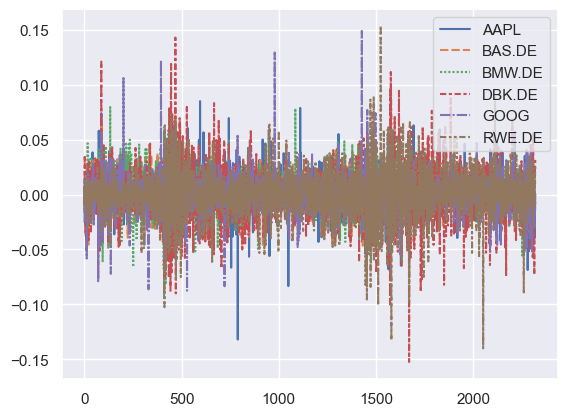

In [8]:
sns.lineplot(data = data);

In [9]:
np.mean(data.iloc[0])

-0.005383706387265634

In [10]:
data.iloc[0]

AAPL     -0.016035
BAS.DE    0.006319
BMW.DE    0.015356
DBK.DE   -0.010512
GOOG     -0.025532
RWE.DE   -0.001899
Name: 0, dtype: float64

In [11]:
PF = data.mean(axis=1)

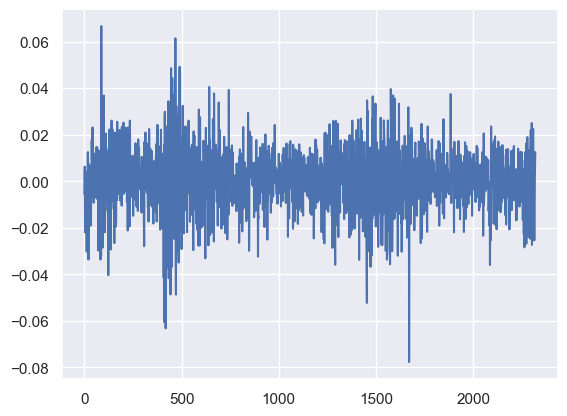

In [12]:
sns.lineplot(x = PF.index, y = PF);

# ARMA-GARCH

In [13]:
from arch import arch_model

In [23]:
am = arch_model(data.AAPL*100, vol="Garch", p=1, o=0, q=1, dist="skewt")

In [24]:
res = am.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 61154.61654623819
Iteration:      2,   Func. Count:     18,   Neg. LLF: 98869.93152945713
Iteration:      3,   Func. Count:     27,   Neg. LLF: 79053.84967924783
Iteration:      4,   Func. Count:     36,   Neg. LLF: 59358.14082619617
Iteration:      5,   Func. Count:     45,   Neg. LLF: 5525.813701642914
Iteration:      6,   Func. Count:     53,   Neg. LLF: 3863.195619977192
Iteration:      7,   Func. Count:     61,   Neg. LLF: 5194.100605920527
Iteration:      8,   Func. Count:     69,   Neg. LLF: 3858.9808662358446
Iteration:      9,   Func. Count:     77,   Neg. LLF: 3851.3725716518884
Iteration:     10,   Func. Count:     85,   Neg. LLF: 3851.161130517036
Iteration:     11,   Func. Count:     93,   Neg. LLF: 3851.1487927506896
Iteration:     12,   Func. Count:    100,   Neg. LLF: 3851.148635967067
Iteration:     13,   Func. Count:    107,   Neg. LLF: 3851.1486342517837
Iteration:     14,   Func. Count:    113,   Neg. LLF: 3851.1

In [26]:
res.resid

0      -1.704896
1      -0.286455
2       0.561185
3      -0.987518
4      -1.245432
          ...   
2312    1.189432
2313   -3.270266
2314   -2.657287
2315   -4.068688
2319   -0.050235
Name: resid, Length: 2134, dtype: float64

In [29]:
def get_residuals(returns):
    am = arch_model(100*returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
    res = am.fit()

    return res.resid


In [31]:
results = get_residuals(data.AAPL)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 61154.61654623819
Iteration:      2,   Func. Count:     18,   Neg. LLF: 98869.93152945713
Iteration:      3,   Func. Count:     27,   Neg. LLF: 79053.84967924783
Iteration:      4,   Func. Count:     36,   Neg. LLF: 59358.14082619617
Iteration:      5,   Func. Count:     45,   Neg. LLF: 5525.813701642914
Iteration:      6,   Func. Count:     53,   Neg. LLF: 3863.195619977192
Iteration:      7,   Func. Count:     61,   Neg. LLF: 5194.100605920527
Iteration:      8,   Func. Count:     69,   Neg. LLF: 3858.9808662358446
Iteration:      9,   Func. Count:     77,   Neg. LLF: 3851.3725716518884
Iteration:     10,   Func. Count:     85,   Neg. LLF: 3851.161130517036
Iteration:     11,   Func. Count:     93,   Neg. LLF: 3851.1487927506896
Iteration:     12,   Func. Count:    100,   Neg. LLF: 3851.148635967067
Iteration:     13,   Func. Count:    107,   Neg. LLF: 3851.1486342517837
Iteration:     14,   Func. Count:    113,   Neg. LLF: 3851.1

In [32]:
results

0      -1.704896
1      -0.286455
2       0.561185
3      -0.987518
4      -1.245432
          ...   
2312    1.189432
2313   -3.270266
2314   -2.657287
2315   -4.068688
2319   -0.050235
Name: resid, Length: 2134, dtype: float64

# Copula VaR

In [12]:
u = pv.to_pseudo_obs(data)

In [13]:
cop = pv.Vinecop(u)

In [14]:
cop.aic()

-4674.849171838875

In [15]:
cop.families

[[<BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.student: 2>,
  <BicopFamily.student: 2>,
  <BicopFamily.tll: 11>],
 [<BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>],
 [<BicopFamily.tll: 11>, <BicopFamily.bb8: 10>, <BicopFamily.frank: 5>],
 [<BicopFamily.tll: 11>, <BicopFamily.tll: 11>],
 [<BicopFamily.joe: 6>]]

In [16]:
cop.structure

<pyvinecopulib.RVineStructure>
5 2 2 2 6 6 
2 4 4 6 2 
4 3 6 4 
3 6 3 
6 5 
1 

In [17]:
cop.simulate(100)

array([[0.38785572, 0.29063626, 0.34190539, 0.55358346, 0.84125793,
        0.93660466],
       [0.86702989, 0.52274686, 0.5667038 , 0.39533474, 0.70143041,
        0.18341003],
       [0.72221763, 0.42456683, 0.30146146, 0.72156733, 0.67703225,
        0.27312453],
       [0.38674474, 0.6758432 , 0.61418067, 0.39675594, 0.34673389,
        0.16460542],
       [0.26386292, 0.07384721, 0.3284756 , 0.30696183, 0.29005221,
        0.48414076],
       [0.13042624, 0.61236624, 0.54323299, 0.5664111 , 0.12190078,
        0.17355064],
       [0.82853442, 0.77711855, 0.83903067, 0.8512571 , 0.76789917,
        0.43835655],
       [0.45244725, 0.01835523, 0.03548664, 0.03996602, 0.6667652 ,
        0.11040846],
       [0.8705018 , 0.70612066, 0.91654719, 0.33101679, 0.95929517,
        0.49078703],
       [0.4729793 , 0.97838003, 0.94549633, 0.48762858, 0.96375944,
        0.993197  ],
       [0.3185817 , 0.73873145, 0.88572408, 0.97474205, 0.46304119,
        0.88476632],
       [0.85033326, 0